In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/image_retrieval')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

### Download data

In [0]:
!wget http://www.ee.columbia.edu/~rj2349/index_files/Homework1/Homework1.zip
!unzip Homework1.zip -d data
!rm Homework1.zip

In [0]:
def read_data(folder, grayscale=True):
    '''Read data from the folder

    Parameters
    ----------
    folder: str, the directory with images
    grayscale: bool, apply grayscaling on the RGB or not
    -------
    Returns:
    files: np.ndarray, array with images'''

    # parse images
    files = next(os.walk(folder))[2]
    files = sorted(files)
    # open images
    files = np.array(list(map(lambda x: np.array(Image.open(os.path.join(folder, x))), files)))
    # apply or not grayscaling
    if grayscale:
        if len(files.shape) == 4:
            files = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), files)))

    return files

In [41]:
%%time
data = read_data('data')

CPU times: user 19.3 s, sys: 14.2 s, total: 33.6 s
Wall time: 35.3 s


In [5]:
print('The images count - {} items'.format(len(data)))
print('Shape of one image - {}'.format(data[0].shape))
print('The data size - {} Mbytes'.format(data.nbytes // 10**6))

The images count - 2000 items
Shape of one image - (480, 640)
The data size - 614 Mbytes


Task 1 - Compute histograms

In [0]:
def compute_histogram(image, bins=256):
    '''Vanilla computing of the histogram'''
    flat = image.reshape(-1).astype(np.int64)
    bins = np.bincount(flat, minlength=bins)
    
    return bins

Compare two implementations:

In [62]:
%%time
hist_one = compute_histogram(data[7], bins=256)

CPU times: user 5.04 ms, sys: 1.9 ms, total: 6.94 ms
Wall time: 10.6 ms


In [65]:
%%time
hist_two, _ = np.histogram(data[7], bins=256)

CPU times: user 12.1 ms, sys: 25.1 ms, total: 37.2 ms
Wall time: 47.5 ms


In [66]:
print('Difference between implementations (MSE) - {}'.format(((hist_one - hist_two)**2).mean()))

Difference between implementations (MSE) - 1012241.765625


Compute normalized histograms for all images in the dataset and save as array:

In [77]:
%%time 
histograms = np.array(list(map(compute_histogram, list(data))))

CPU times: user 3.23 s, sys: 69.2 ms, total: 3.3 s
Wall time: 3.32 s


In [0]:
histograms = np.array(list(map(lambda x: x / np.linalg.norm(x), list(histograms))))

Task 2 - Implement L2-distance function

In [0]:
def l2_distance(vector_one, vector_two):
    '''L2-norm between two vectors'''
    return np.linalg.norm(vector_one - vector_two)**2

In [80]:
l2_distance(histograms[156], histograms[145])

1.150848539656459

Task 3 - Perform query with test images and visualize results

In [0]:
queries = ['ukbench00004.jpg', 
           'ukbench00040.jpg', 
           'ukbench00060.jpg', 
           'ukbench00588.jpg',
           'ukbench01562.jpg']

# positional indexes in the database
ids = [5, 41, 61, 589, 1563]

In [0]:
def query(dataset, query_image, n_neighbors=11, similarity_func=l2_distance):
    '''Make a query in the dataset using query image. 
    Find the similar to query images few neighbors.

    Parameters
    ----------
    dataset: np.ndarray, entire data
    query_image: np.ndarray, query object
    n_neighbors: int, number of the closest objects to find
    similarity_func: function, two arguments
    -------
    Returns:
    indexes: list, positional indexes of the neighbors'''
    output_dict = {}
    
    # go through dataset
    for i in range(len(dataset)):
        output_dict[i] = similarity_func(query_image, dataset[i])
    
    # sort the results
    sorted_dict = sorted(output_dict.items(), 
                         key=lambda x: x[1], 
                         reverse=False)
    # get indexes of the results
    indexes = list(map(lambda x: x[0], sorted_dict[:n_neighbors]))
    
    return indexes

In [0]:
# find the neighbors for all test images

indexes = []

for id in ids:
    
    temporary = query(histograms, histograms[id])
    indexes.append(temporary)
    
indexes = np.array(indexes)

In [0]:
def plot_examples_knn(data, queries, indexes):
    '''Plot the closest data samples 
    to the image from query.
    
    Parameters
    ----------
    data : np.ndarray, 4D tensor with images, full data
    queries: np.ndarray, 4D tensor with query images
    indexes :  np.ndarray, the indexes of the closest objects.
    If query image in the database, it is included in the results.
    '''
    # plot the clusters and its elements in the grid
    nrows = indexes.shape[0]
    ncols = indexes.shape[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10), dpi=150)
    # plot examples
    for i in range(nrows):   
        for j in range(ncols):
            
            picture = data[indexes[i][j]]
            # plot pictures
            axes[i, j].imshow(picture, cmap='gray')
            axes[i, j].axis('off')
            
            if j > 0:
                axes[i, j].set_title('#{y}'.format(y=indexes[i, j]))
            else:
                axes[i, j].set_title('Picture\n{}'.format(indexes[i, 0]))

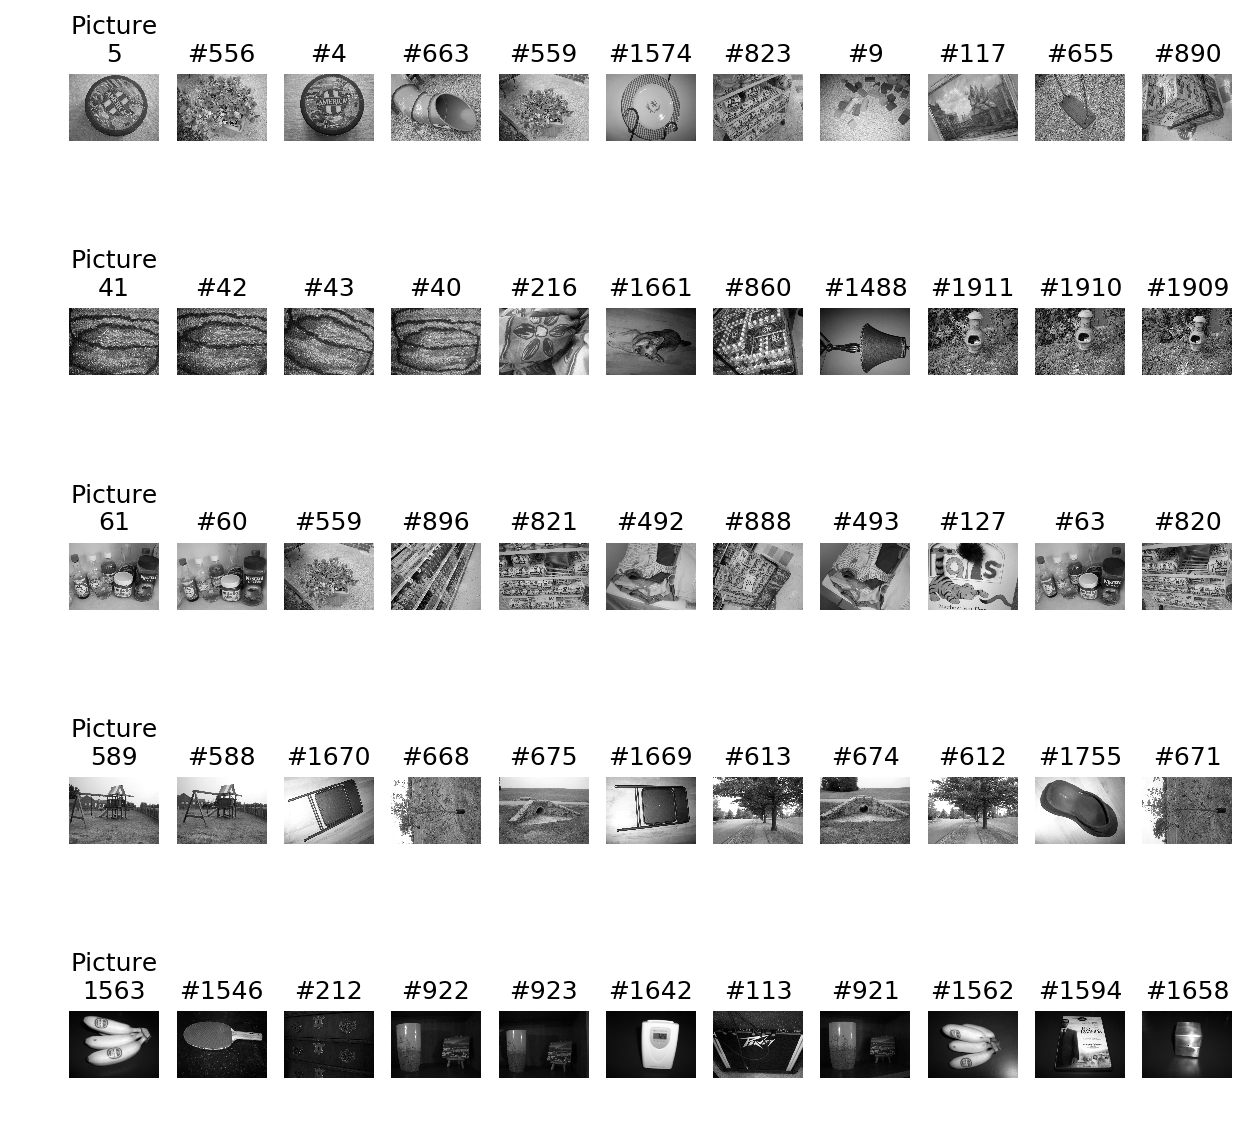

In [86]:
plot_examples_knn(data, data[ids], indexes)

Task 4 - Plot Precision-Recall curve (Not finished yet)

In [0]:
def l2_similarity(vector_one, vector_two):
  
    return np.abs(np.dot(vector_one, vector_two)) 

def prc(dataset, query_image, n_neighbors, similarity_func):
  
    thresholds = np.arange(0, 1.05, 0.05)
    #thresholds = [0.5]
    
    points = []
    
    for th in thresholds:
    
        output_dict = {}
    
        for i in range(len(dataset)):
            output_dict[i] = similarity_func(query_image, dataset[i])
        
        sorted_dict = sorted(output_dict.items(), 
                             key=lambda x: x[1], 
                             reverse=True)
   
        values_all = np.array(list(map(lambda x: x[1], sorted_dict)))
        values_top = np.array(values_all[:n_neighbors])
      
        precision = (values_top > th).sum() / len(values_top)
        recall = (values_top > th).sum() / (values_all > th).sum()
        
        points.append([precision, recall])
        
    return points

In [88]:
l = prc(histograms, histograms[4], 11, l2_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


Task 5

The built system for image retrieval works pretty well for new neighbors (like second, or third the most closest object), but with higher number of neighbors there are some mistakes. I used comparing between histograms of the grayscaled images, so there are a lot of different images in the sense of semantic (for example, picture #589 and #1670), but similar in the distribution of colors. So, this metric isn't robast in the sense what we want to see. And possible improvement: add color histogram, or use some CNN features on the images.